<a href="https://colab.research.google.com/github/prasadanilmore/CNN-Project-Leaf-Classification/blob/main/Vit_Leaf_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preparation

In [1]:
import PIL.Image

In [2]:
!pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 13.8 MB/s 
     |████████████████████████████████| 5.8 MB 61.6 MB/s 
     |████████████████████████████████| 182 kB 56.8 MB/s 
     |████████████████████████████████| 212 kB 63.8 MB/s 
     |████████████████████████████████| 132 kB 59.4 MB/s 
     |████████████████████████████████| 127 kB 49.0 MB/s 
     |████████████████████████████████| 7.6 MB 64.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [3]:
from datasets import load_dataset

ds = load_dataset('beans')
ds

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

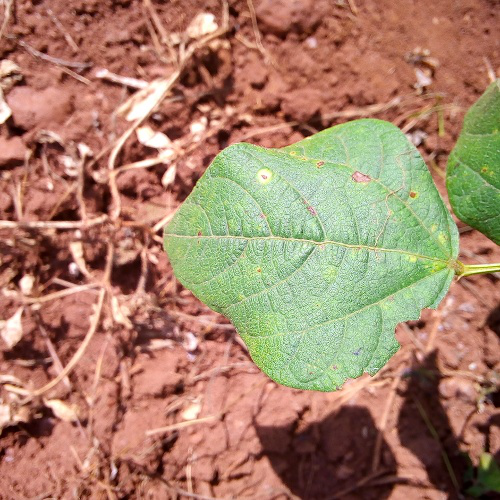

In [4]:
image = ds["train"][400]["image"]
image

In [5]:
ds["train"].features["labels"]

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

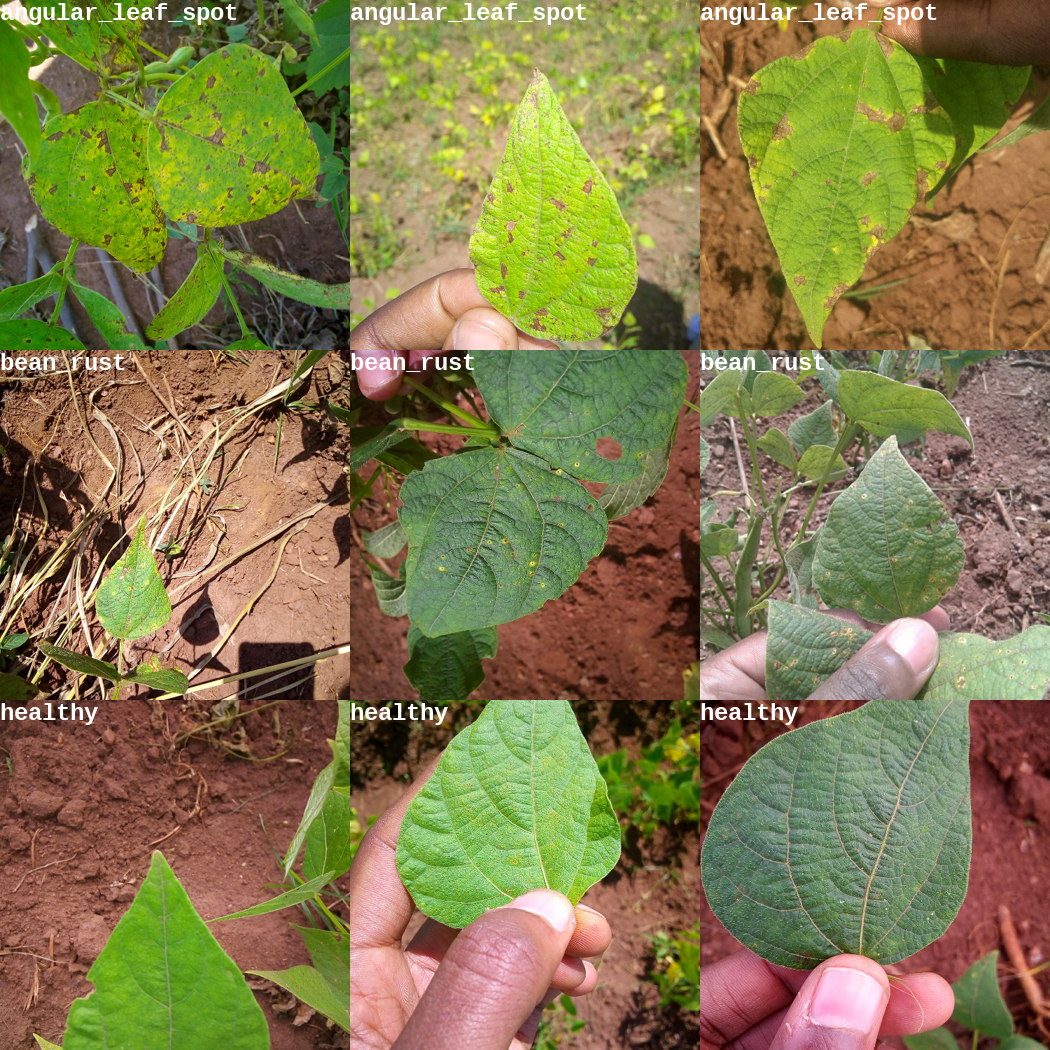

In [6]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)


## Modelling

In [7]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [8]:
feature_extractor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [9]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[ 0.7882,  0.6706,  0.7098,  ..., -0.1922, -0.1294, -0.1765],
          [ 0.7020,  0.6000,  0.6863,  ..., -0.2863, -0.1608, -0.1608],
          [ 0.4824,  0.4039,  0.4667,  ..., -0.1922, -0.0196,  0.0275],
          ...,
          [ 0.3804,  0.5294,  0.4824,  ..., -0.8275, -0.8196, -0.8039],
          [ 0.0902,  0.3725,  0.3804,  ..., -0.8667, -0.8431, -0.8510],
          [-0.0510,  0.2784,  0.3176,  ..., -0.8588, -0.8275, -0.8275]],

         [[ 0.4902,  0.3490,  0.3804,  ..., -0.6078, -0.5373, -0.5843],
          [ 0.3569,  0.2000,  0.3176,  ..., -0.7176, -0.6000, -0.5922],
          [ 0.0431, -0.0902,  0.0510,  ..., -0.6392, -0.4745, -0.4275],
          ...,
          [-0.2235, -0.0510, -0.0902,  ..., -0.9765, -0.9608, -0.9373],
          [-0.5059, -0.2078, -0.1922,  ..., -0.9922, -0.9922, -1.0000],
          [-0.6471, -0.3020, -0.2471,  ..., -0.9843, -0.9765, -0.9843]],

         [[ 0.4353,  0.2706,  0.3098,  ..., -0.7176, -0.6392, -0.6863],
          [ 0

In [10]:
ds = load_dataset('beans')

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
prepared_ds = ds.with_transform(transform)

In [12]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1922, -0.2549],
          [-0.6078, -0.6000, -0.5843,  ..., -0.0353, -0.0196, -0.2706],
          [-0.6314, -0.6314, -0.6157,  ..., -0.2392, -0.3647, -0.2314],
          ...,
          [-0.5373, -0.5529, -0.5765,  ..., -0.0745, -0.0431, -0.0980],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3176,  0.1608,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2784,  0.1451,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3569, -0.3176, -0.5608],
          [-0.7490, -0.7490, -0.7647,  ..., -0.5373, -0.6627, -0.5373],
          ...,
          [-0.7725, -0.7882, -0.8196,  ..., -0.2314, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1843,  0.3176,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0745,  0.2863,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3647, -0.7333],
          [-0

In [13]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [14]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


<ipython-input-14-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [15]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)
print(model.device)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cpu


In [16]:
from transformers import TrainingArguments



In [17]:
training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=False,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

In [19]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1034
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 260
  Number of trainable parameters = 85800963


Step,Training Loss,Validation Loss,Accuracy
100,0.153300,0.041847,1.000000
200,0.016100,0.059572,0.977444


***** Running Evaluation *****
  Num examples = 133
  Batch size = 8
Saving model checkpoint to ./vit-base-beans/checkpoint-100
Configuration saved in ./vit-base-beans/checkpoint-100/config.json
Model weights saved in ./vit-base-beans/checkpoint-100/pytorch_model.bin
Image processor saved in ./vit-base-beans/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 133
  Batch size = 8
Saving model checkpoint to ./vit-base-beans/checkpoint-200
Configuration saved in ./vit-base-beans/checkpoint-200/config.json
Model weights saved in ./vit-base-beans/checkpoint-200/pytorch_model.bin
Image processor saved in ./vit-base-beans/checkpoint-200/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./vit-base-beans/checkpoint-100 (score: 0.04184732958674431).
Saving model checkpoint to ./vit-base-beans
Configuration saved in ./vit-base-beans/config.json
Model weights saved in ./vit-bas

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1356
  train_runtime            =  0:03:17.70
  train_samples_per_second =       20.92
  train_steps_per_second   =       1.315


In [21]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 133
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =        1.0
  eval_loss               =     0.0418
  eval_runtime            = 0:00:02.67
  eval_samples_per_second =     49.786
  eval_steps_per_second   =      6.364
